# Daily workflow - troselab (DRAFT)

`TR TODO: Jupyter ipywidget GUI`

(check Daniel's ipysheet mouse entry GUI for inspiration)

1. Upload to analysis server
    1. automatic (rcopy with file consolidation)?
    2. WinSCP?

    
2. Session ingest - Have this script parse the user folder. 
    1. retrieve login name  **DONE**
    2. parse user storage folder for SessionIDs, ScanIDs **DONE**
    3. intersect with 'Session' tables **DONE**
    4. FIRST STEP: session ingestion of new data  **DONE**
        1. have ipywidget with list of data to be ingested with checkbox  **DONE**
        2. have dropdowns next to SessionsFetch that expose 'Project', 'Anatomical Location', 'Equipment' (NOTE: have me or admin accept new entries? Or user?) - have a user default **DONE**
            1. ***TODO*** include a mini2p settings shorthand in elements `imaging.ProcessingParamSet`.
        3. IMPORTANT: Have dropdown for `Same_Location_as_Session` - default: same session
            1. Include `Same_Location_as_Session` key in `Session` table (default same session)
            2. Update after Session ingest
        4. have central 'START' button **DONE**
        5. Combine session entry with automatic RSpace entry (**DONE***)
            0. Include rspace in install requirements!
            1. Extract parent folder IDs under 'experiments' from RSpace (add RSpace API key and URL to djconfig )
            2. Intersect list with animal ID from session ingest
            3. Create new document with `YYYY-MM-DD_SessionID`
            4. Append content as verbose tables using Pandas df.to_html (`html_table = df.to_html()`)
            5. ***DONE*** IMPORTANT: Push RSpace document ID and noteobook URL in Sessions database!
        5. OPTIONAL: Have a notebook section to enter and insert Session Notes
        6. OPTIONAL: Submit Sessions to pyrat. Not sure if necessary.
        7. TODO: Think if splitting projects off to different database suffixes (and differnt associated tables makes sense from here. Seems reasonable given the focus on the user root directory here.
        8. ***DONE***: Implement auto animal pyrat ingest if needed. Crashes now.
        9. ***DONE***: Make sure that multi-scan sessions are properly treated. Currently they are not detected as such by the GUI. Make sure ingestion behavior is appropriate.


3. Scan ingest / 1st stage s2p processing: 
    1. ***NO!*** have another list with checkboxes (default checled) - now with all first stage scans of the newly ingested sessions. Have dropdown boxes with s2p parameteres. User default is selected. Followed by 'START'
    2. TODO: suppress s2p output, just have progress bars
    3. OPTIONAL: Have a notebook section to enter and insert Scan Notes
    4. OPTIONAL: Submit sessions, scans and Notes to RSPACE! Upload s2p average image, max image, Source image and Rastermap 
    5. Upload templates to rspace session, upload movie to rspace session
    

4. Scan Curation
    1. DIFFERENT NOTEBOOK (or different Notebook section)
    2. Make intersection of folder with database
        1. list _all_ scans
        2. have all non-curated red - the others green
        3. bhave non-processed scans grey
        4. have 'CURATE LOCALLY WITH s2P' buttons behind all scans. This button should spawn a local suite2p GUI which directly loads the respective suite2p stats.npy file from the server. Folder settings for server need to be set in datajoint.json file.

5. SERVER: Database backup and Data folder backup
    1. Have cronjob backup database to ana2 and isilon (midnight, incremental - only add, no delete. Increment ID to be reversible?)
    2. Have cronjob backup data folders to ana2 and isilon (midnight, incremental - only add, no delete)

## Login

Either log in via a local config file (see [01_pipeline](./01_pipeline.ipynb)), or enter login information manually. If you are don't have your login information, contact the administrator.


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging
from adamacs.ingest import session as isess
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
dj.__version__

[2023-03-20 08:23:26,162][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-03-20 08:23:26,220][INFO]: Connected tobiasr@172.26.128.53:3306


'0.14.0'

### RSpace connection

In [2]:
URL=dj.config['custom'].get('rspace_URL')
API_KEY=dj.config['custom'].get('rspace_API_key')
api = eln.ELNClient(URL, API_KEY)
api.get_status()

{'message': 'OK', 'rspaceVersion': '1.80.1'}

## Activation
Next, import from `adamacs.pipeline` to activate the relevant schema.

In [3]:
from adamacs.utility import *
from adamacs.nbgui import *
from adamacs.pipeline import subject, session, surgery, scan, equipment

Assign easy names for relevant tables

In [4]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath()
    )

## Cleaning. Use with caution!

In [66]:
session.Session.delete()

[2023-03-20 08:23:15,199][INFO]: Deleting 12 rows from `tobiasr_scan`.`_scan_info__field`
[2023-03-20 08:23:15,203][INFO]: Deleting 12 rows from `tobiasr_scan`.`_scan_info__scan_file`
[2023-03-20 08:23:15,206][INFO]: Deleting 12 rows from `tobiasr_scan`.`_scan_info`
[2023-03-20 08:23:15,209][INFO]: Deleting 14 rows from `tobiasr_scan`.`scan_location`
[2023-03-20 08:23:15,213][INFO]: Deleting 14 rows from `tobiasr_scan`.`scan_path`
[2023-03-20 08:23:15,252][INFO]: Deleting 3528 rows from `tobiasr_imaging`.`__activity__trace`
[2023-03-20 08:23:15,256][INFO]: Deleting 3 rows from `tobiasr_imaging`.`__activity`
[2023-03-20 08:23:15,399][INFO]: Deleting 3528 rows from `tobiasr_imaging`.`__fluorescence__trace`
[2023-03-20 08:23:15,403][INFO]: Deleting 3 rows from `tobiasr_imaging`.`__fluorescence`
[2023-03-20 08:23:15,424][INFO]: Deleting 1899 rows from `tobiasr_imaging`.`__mask_classification__mask_type`
[2023-03-20 08:23:15,428][INFO]: Deleting 3 rows from `tobiasr_imaging`.`__mask_classif

13

## 1. Data upload
(not implemented currently)

## 2. Session ingest

### Define ingest GUI functions

In [5]:
# Tobias Rose 2023: Routine ingest helpers

import ipywidgets as widgets
from natsort import natsorted, ns
import re
from tqdm import tqdm

def select_sessions(IngestedSessionDirA, AvailableSessionDirB, Project, Recording_Location, Equipment, s2pparm, SessionNotes):
    
    # Personal default values
    user_defaults = get_user_defaults(AvailableSessionDirB)
       
    # Define the widgets
    session_dropdowns = []
    session_checkboxes = []
    for i, session_list in enumerate(AvailableSessionDirB):
        # Dropdowns for Project, Recording Location, Equipment

        current_session = get_session_key_from_dir([session_list])

        # check if directory session is already ingested - if yes: populate GUI with table values. If no: use user defaults
        query = session.Session() & f'session_id = "{current_session[0]}"'

        count = len(query.fetch('session_id'))
        # print(current_session)
        
        if count > 0:
            # print("HELLO")
            # get the project associated with a session
            query = session.ProjectSession() & f'session_id = "{current_session[0]}"'
            project_dropdown_value = query.fetch("project")
            # get the location associated with a session
            query = session.Session() * scan.ScanLocation() & f'session_id = "{current_session[0]}"'
            location_dropdown_value = query.fetch("anatomical_location")
            # get the equipment associated with a session
            query = session.Session() * scan.Scan() & f'session_id = "{current_session[0]}"'
            equipment_dropdown_value = query.fetch("scanner")
            # get the note associated with a session
            query = session.SessionNote() & f'session_id = "{current_session[0]}"'
            session_note_textbox_value = query.fetch("session_note")
            if len(session_note_textbox_value) == 0:
                session_note_textbox_value = ["none"]    
        else:
            project_dropdown_value = Project[user_defaults[i][0]]
            location_dropdown_value = [Recording_Location[user_defaults[i][1]]]
            equipment_dropdown_value = [Equipment[user_defaults[i][2]]]
            session_note_textbox_value = ["none"]
        
        project_dropdown = widgets.Dropdown(options=Project, value=project_dropdown_value, description="Project:")
        location_dropdown = widgets.Dropdown(options=Recording_Location, value=location_dropdown_value[0], description="Location:")
        equipment_dropdown = widgets.Dropdown(options=Equipment, value=equipment_dropdown_value[0], description="Setup:")
        s2pparms_dropdown = widgets.Dropdown(options=s2pparm, value=s2pparm[user_defaults[i][3]], description="s2p parm:")
        session_note_textbox = widgets.Text(value=session_note_textbox_value[0], description='Session comment:')

        session_dropdowns.append((project_dropdown, location_dropdown, equipment_dropdown, s2pparms_dropdown, session_note_textbox))

        # Checkbox for Process?
        session_checkbox = widgets.Checkbox(description='run?', layout=widgets.Layout(width='auto'))
        session_checkboxes.append(session_checkbox)

    # Display the widgets
    output = widgets.Output()

    with output:
        # Display the Sessions labels and associated dropdowns and checkboxes
        hbox_list = []
        for i, session_list in enumerate(AvailableSessionDirB): #unique_directory_strings(SessionDirA, SessionDirB)
            # Create an HBox to hold the label and associated dropdowns and checkbox
            hbox = widgets.HBox()
            hbox.children = [
                widgets.Label(value=session_list + ':', layout=widgets.Layout(width='1800px')), 
                session_dropdowns[i][0],
                session_dropdowns[i][1],
                session_dropdowns[i][2],
                session_dropdowns[i][3],
                session_dropdowns[i][4],
                session_checkboxes[i]
            ]
            if session_list in unique_directory_strings(IngestedSessionDirA, AvailableSessionDirB):
                hbox.children[0].value = '*' + session_list + ':'
                hbox.children[6].value = True
            else:
                hbox.children[6].value = False
                hbox.children[1].disabled = True
                hbox.children[2].disabled = True
                hbox.children[3].disabled = True
                hbox.children[4].disabled = True
                hbox.children[5].disabled = True
            hbox_list.append(hbox)

        vbox = widgets.VBox(hbox_list, layout=widgets.Layout(flex='0 0 auto', overflow_y='scroll'))
        # Display the commit button
        commit_button = widgets.Button(description='Commit', layout=widgets.Layout(width='auto'))
        display(vbox, commit_button)

        # Define the callback function for the commit button
        def commit_button_clicked(b):
            selected_sessions = [AvailableSessionDirB[i] for i in range(len(AvailableSessionDirB)) if session_checkboxes[i].value]
            selected_projects = [session_dropdowns[i][0].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i].value]
            selected_locations = [session_dropdowns[i][1].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i].value]
            selected_equipment = [session_dropdowns[i][2].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i].value]
            selected_s2pparms = [session_dropdowns[i][3].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i].value]
            entered_session_note = [session_dropdowns[i][4].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i].value]

            selected_scans = get_scan_key_from_dir(selected_sessions)
            selected_sessions = get_session_key_from_dir(selected_sessions)

            output.clear_output()
            with output:
                # print('Selected Sessions:', selected_sessions)
                # print('Selected Scans:', selected_scans)
                # print('Selected Projects:', selected_projects)
                # print('Selected Recording Locations:', selected_locations)
                # print('Selected Equipment:', selected_equipment)
                # print('Selected S2PParms:', selected_s2pparms)

                # Ingest selected sessions here
                populate_settings = {'display_progress': False, 'suppress_errors': True, 'processes': 1}

                for i, sessi in enumerate(tqdm(selected_sessions, desc='Current Session: {}')):
                    # ingest sessions
                    isess.ingest_session_scan(sessi, verbose=False, project_key=selected_projects[i], equipment_key=selected_equipment[i], location_key=selected_locations[i], software_key='ScanImage')
                    # update / insert session info based on user choice from above
                    try:
                        session.SessionNote.insert1({'session_id': sessi, 'session_note': entered_session_note[i]})
                    except:
                        session.SessionNote.delete_quick({'session_id': sessi})
                        session.SessionNote.insert1({'session_id': sessi, 'session_note': entered_session_note[i]})
                    
                    # update scaninfo based on user choice from above
                    # get the scans associated with a session
                    query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
                    scans_to_process = query.fetch("scan_id")

                    for j, scansi in enumerate(scans_to_process):
                        try:
                            scan.Scan.update1({'session_id': sessi, 'scan_id': scansi, 'scan_notes': entered_session_note[i]})
                        except:
                            scan.Scan.insert1({'session_id': sessi, 'scan_id': scansi, 'scan_notes': entered_session_note[i]})
                        try:
                            scan.ScanLocation.update1({'session_id': sessi, 'scan_id': scansi, 'anatomical_location': selected_locations[i]})
                        except: 
                            scan.ScanLocation.insert1({'session_id': sessi, 'scan_id': scansi, 'anatomical_location': selected_locations[i]})
                        
                        # print('Ingested and processed Scan:', scansi)
                    
                    # SCAN Processing 
                    scan.ScanInfo.populate(**populate_settings)

                    for j, scansi in enumerate(scans_to_process):
                        query = session.SessionDirectory() & 'session_id = "' + sessi + '"'
                        print(query)
                        dir_proc = query.fetch('session_dir')[0]
                    imaging.ProcessingTask.insert1((sessi, scansi, 0, dir_proc, 'trigger'), skip_duplicates=True)
                    ## Make RSpace entries 

                    query = session.Session() * subject.User() & f'session_id = "{sessi}"'
                    animalID = query.fetch("subject")[0]
                    date = query.fetch("session_datetime")[0].strftime("%Y-%m-%d")
                    userID = query.fetch("initials")[0]
                    sessionID = query.fetch("session_id")[0]
                    fetchtable = session.Session() * scan.ScanPath() * session.SessionUser() * session.ProjectSession() * session.SessionNote() * scan.Scan() & f'session_id = "{sessi}"'

                    make_rspace_session_document(animalID, sessi, date, userID, fetchtable) # TODOO
                
                
                print('Ingested Sessions:', selected_sessions)

        # Attach the callback function to the commit button
        commit_button.on_click(commit_button_clicked)

    # Display the output
    display(output)
        
def make_rspace_session_document(animalID, sessionID, date, userID, fetchtable):

    # find 'Experiments' folder and get ID
    folders = api.list_folder_tree()
    experiments_ids = []
    for record in folders['records']:
        if record['name'] == 'Experiments':
            experiments_ids.append(record['id'])

    # find folders under 'Experiments' folder
    names_and_ids = []
    subfolders = api.list_folder_tree(experiments_ids[0])
    names_and_ids.append([(record['name'], record['id']) for record in subfolders['records']])

    # find matches with animal IDs
    match_found = any(animalID in item[0] for sublist in names_and_ids for item in sublist)

    # if found, find folder id matching that animal
    if match_found:
        save_folder_id = [x[1] for sublist in names_and_ids for x in sublist if animalID in x[0]][0]
    else:
        # if not generate the directory
        new_folder = api.create_folder(name=f"{userID}_{animalID}", parent_folder_id=experiments_ids[0], notebook=True)
        save_folder_id = new_folder['id']


    # find matches with document IDs

    # find all documents in the animal folder
    all_animal_documents = api.list_folder_tree(save_folder_id)
    doc_names_and_ids = []
    doc_names_and_ids.append([(record['name'], record['id']) for record in all_animal_documents['records']])
    # find matches with sessionID
    match_found = any(sessionID in item[0] for sublist in doc_names_and_ids for item in sublist)

    if match_found:
        ids = [id for string, id in doc_names_and_ids[0] if sessionID in string]
        new_doc = {"id": ids[0]}
    else:
        new_doc = api.create_document(name=f"{date}_{sessionID}", parent_folder_id=save_folder_id)

    # create RSpace document
    df = fetchtable.fetch(format='frame')
    html_table = df.to_html()
    content = html_table
    api.append_content(new_doc['id'], content)

    # ingest document in rspace table
    session.SessionRspace.insert1({'session_id': sessionID, 'rspace_id': new_doc['id']}, skip_duplicates=True)
    # ingest animal folder id in subject Rspace table
    subject.SubjectRspace.insert1({'subject': animalID, 'rspace_subject_id': save_folder_id}, skip_duplicates=True)
    # session.SessionRspace.insert1({'rspace_id': new_doc['id'], 'rspace_url': new_doc['_links'][0]['link']})
def get_date_key_from_dir(directory):
    return directory.split("_")[-1]

def get_session_dir_key_from_dir(directory):
    return [path.split('/')[-1] for path in directory]
     
def get_scan_dir_key_from_dir(directory):
    return [path.split('/')[-1] for path in directory]

def get_session_key_from_dir(string):
    result = [re.search(r'sess\S+', item).group(0) for item in string]
    return result

def get_user_initials_from_dir(string):
    result = [name[:2] for name in string]
    return result

def get_scan_key_from_dir(string):
    result = [re.search(r'scan\S+_', item).group(0)[:-1] for item in string]
    return result

def unique_directory_strings(dirs1, dirs2):
    set1 = set(dirs1)
    set2 = set(dirs2)
    common_dirs = list(set1.intersection(set2))
    unique_dirs = list(set(set1.union(set2)) - set(common_dirs))
    return unique_dirs

def get_user_defaults(directory):
    RN = [1, 1, 2, 0]
    JJ = [2, 6, 2, 0]
    TR = [0, 6, 3, 0]
    DB = [4, 0, 1, 2]
    NK = [5, 0, 2, 2]
    
    user_initials = get_user_initials_from_dir(directory)

    user_arrays = {}
    for initial in user_initials:
        values = locals()[initial]
        user_arrays[initial] = values

    new_array = [user_arrays[initial] for initial in user_initials]
    return new_array

#### Populate ingest GUI variables from DJ tables and manual arrays

In [6]:
# DJ tables
Project = project.fetch('project')
Equipment = equipment.Equipment().fetch('scanner')
Recording_Location = surgery.AnatomicalLocation().fetch('anatomical_location')

session_dirs_ingested = session.SessionDirectory.fetch('session_dir')
scan_dirs_ingested = scan.ScanPath.fetch('path')
SessionsDirArrayingested = get_session_dir_key_from_dir(session_dirs_ingested)
ScanDirArrayingested = get_scan_dir_key_from_dir(scan_dirs_ingested)

SessionNotes = session.SessionNote.fetch('session_note')

# Manual arrays
s2pparm = ['mini2p_a', 'mini2p_b', 'bench2p_a']

In [7]:
imaging.ProcessingParamSet()

paramset_idx,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,suite2p,"TR: Mini2p (single channel, single plane, non-rigid, 15Hz)",96a32724-4dd0-4faf-c88d-6073ad7199a2,=BLOB=
1,suite2p,"TR: Bench2p (single channel, single plane, non-rigid, 30Hz)",c2e80fa9-6fdb-5706-48ac-b15cf1449e92,=BLOB=


#### Parse user data root dir and sort by date-string in directory name

In [8]:
dataroot = dj.config['custom']['exp_root_data_dir'][0]
dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and 'sess' in d]
sorted_dirs_root = natsorted(dirs_root, key=get_date_key_from_dir, reverse = True)

### Generate Ingest GUI

In [9]:
# print("\033[1m" + 'Select:                                           Project        Location  Setup        s2p parm' + "\033[0m" )
print("\033[1m" + 'INGEST GUI' + "\033[0m" )
selected_data = select_sessions(SessionsDirArrayingested, sorted_dirs_root, Project, Recording_Location, Equipment, s2pparm, SessionNotes)

INGEST GUI


Output()

In [10]:
scan.Scan  * scan.ScanInfo() * scan.ScanPath()

session_id,scan_id,user_id,path,scanner,acq_software,scan_notes free-notes,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan
sess9FGLE1FN,scan9FGLE1FN,7,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,bench2p,ScanImage,Rukhmanis awesome first recording,1,1,1,27000,0,nan,nan,nan,29.9784,1,63.1769,0.712867,None,900.648


## Run imaging processing tasks

In [11]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FGLE1FN,scan9FGLE1FN,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,trigger


In [12]:
imaging.Processing.populate(display_progress=True,  suppress_errors=True)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

using TorchFFT
{'data_path': ['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN'], 'tiff_list': ['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN/scan9FGLE1FN_RN_OPI-1681_00001.tif']}
tif
** Found 1 tifs - converting to binary **
time 24.31 sec. Wrote 27000 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: Applying builtin classifier at /home/tobiasr/suite2p/suite2p/classifiers/classifier.npy
----------- REGISTRATION
NOTE: estimated bidiphase offset from data: 1 pixels
Reference frame, 18.87 sec.
Registered 8000/27000 in 144.34s
Registered 16000/27000 in 271.18s
Registered 24000/27000 in 397.46s
Registered 27000/27000 in 443.11s
----------- Total 475.60 sec
Registration metrics, 26.08 sec.
----------- ROI DETECTION
Binning movie in chunks of length 30
Binned movie of size [899,42

Processing: 100%|██████████| 1/1 [10:53<00:00, 653.95s/it]


[]

### Do manual suite2p curation now!
### Then: populate curation table

In [13]:
imaging.Curation().create1_from_processing_task({'session_id': "sess9FGLE1FN", 'scan_id': "scan9FGLE1FN", "paramset_idx":0})

In [14]:
imaging.Curation()

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FGLE1FN,scan9FGLE1FN,0,1,2023-03-20 08:36:02,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,0,


TODO: 
- figure out how to re-run s2p after curation


Populate imaging.MotionCorrection

In [15]:
populate_settings = {'display_progress': False, 'suppress_errors': True, 'processes': 1}
imaging.MotionCorrection.populate(**populate_settings)

[2023-03-20 08:40:57,407][ERROR]: 'nblocks'


[({'session_id': 'sess9FGLE1FN',
   'scan_id': 'scan9FGLE1FN',
   'paramset_idx': 0,
   'curation_id': 1},
  "KeyError: 'nblocks'")]

In [16]:
imaging.MotionCorrection()

session_id,scan_id,paramset_idx,curation_id,motion_correct_channel 0-based indexing


In [40]:
imaging.Segmentation.populate(**populate_settings)

[]

In [41]:
imaging.Segmentation()

session_id,scan_id,paramset_idx,curation_id
sess9FGLE1FN,scan9FGLE1FN,0,1
sess9FGLE1FN,scan9FGLE1FN,0,2
sess9FGLE1FN,scan9FGLE1FN,0,3


In [42]:
imaging.MaskClassification.populate(**populate_settings)

[]

In [43]:
imaging.MaskClassification()

session_id,scan_id,paramset_idx,curation_id,mask_classification_method
sess9FGLE1FN,scan9FGLE1FN,0,1,suite2p_default_classifier
sess9FGLE1FN,scan9FGLE1FN,0,2,suite2p_default_classifier
sess9FGLE1FN,scan9FGLE1FN,0,3,suite2p_default_classifier


In [44]:
imaging.Fluorescence.populate(**populate_settings)

[]

In [48]:
imaging.Fluorescence()

session_id,scan_id,paramset_idx,curation_id
sess9FGLE1FN,scan9FGLE1FN,0,1
sess9FGLE1FN,scan9FGLE1FN,0,2
sess9FGLE1FN,scan9FGLE1FN,0,3


In [49]:
imaging.Activity.populate(**populate_settings)

In [50]:
imaging.Activity()

session_id,scan_id,paramset_idx,curation_id,extraction_method
sess9FGLE1FN,scan9FGLE1FN,0,1,suite2p_deconvolution
sess9FGLE1FN,scan9FGLE1FN,0,2,suite2p_deconvolution
sess9FGLE1FN,scan9FGLE1FN,0,3,suite2p_deconvolution


## Exploring data

In [54]:
session_key = (session.Session & 'session_id = "sess9FGLE1FN"').fetch('KEY')[0]
session_key

{'session_id': 'sess9FGLE1FN'}

In [57]:
scan.ScanInfo & session_key

scan.ScanInfo.Field & session_key

session_id,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
sess9FGLE1FN,scan9FGLE1FN,0,512,512,450.45,450.45,nan,nan,nan,=BLOB=,None


In [58]:
imaging.ProcessingTask * imaging.Processing & session_key

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation","processing_time time of generation of this set of processed, segmented results",package_version
sess9FGLE1FN,scan9FGLE1FN,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,trigger,2023-03-17 18:15:40,


In [59]:
imaging.Curation & session_key

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FGLE1FN,scan9FGLE1FN,0,1,2023-03-17 18:15:40,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,0,
sess9FGLE1FN,scan9FGLE1FN,0,2,2023-03-17 18:15:40,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,0,
sess9FGLE1FN,scan9FGLE1FN,0,3,2023-03-17 18:15:40,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLE1FN_sess9FGLE1FN,0,


In [62]:
curation_key = (imaging.Curation & session_key & 'curation_id=1').fetch1('KEY')
curation_key

{'session_id': 'sess9FGLE1FN',
 'scan_id': 'scan9FGLE1FN',
 'paramset_idx': 0,
 'curation_id': 1}

In [65]:
imaging.MotionCorrection.Summary()

session_id,scan_id,paramset_idx,curation_id,field_idx,ref_image image used as alignment template,average_image mean of registered frames,correlation_image correlation map (computed during cell detection),max_proj_image max of registered frames


In [63]:
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')

DataJointError: fetch1 should only return one tuple. 0 tuples found

## Exploring updates

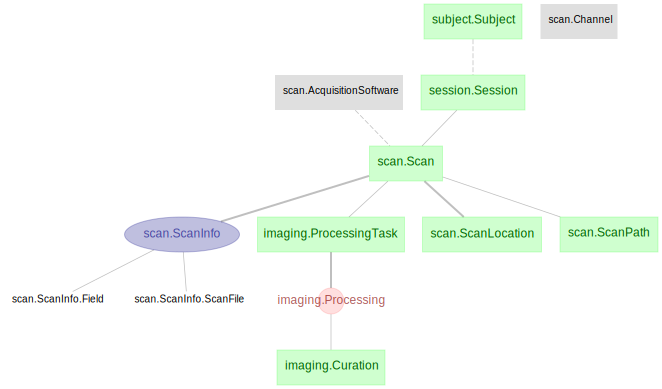

In [32]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging.Processing) + dj.Diagram(imaging.Curation)

In [16]:
from element_calcium_imaging.plotting.widget import main

ModuleNotFoundError: No module named 'element_calcium_imaging.plotting'

selected_data

In [ ]:
sessi = "sess9FG1TAXY"
query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
scans_to_process = query.fetch("scan_id")
for j, scansi in enumerate(scans_to_process):
    print(scansi)

In [ ]:
session.Session() * session.SessionRspace()

In [ ]:
subject.Subject.delete()

### 2.1 Session notes ingest

In [ ]:
current_session = "sess9FGTSPEH"
query = session.Session() * scan.Scan() & f'session_id = "{current_session}"'
equipment_dropdown_value = query.fetch("scanner")
equipment_dropdown_value

## 3. Scan ingest / s2p processing 1st pass

In [ ]:
query = session.Session() * scan.ScanLocation() & f'session_id = "{current_session}"'

In [ ]:
query